# Fit Spikes of HH with AdEx

In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1002 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(2000*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.17s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


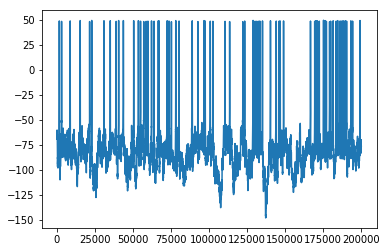

In [7]:
voltage = mon.v[0]/mV
plot(voltage);

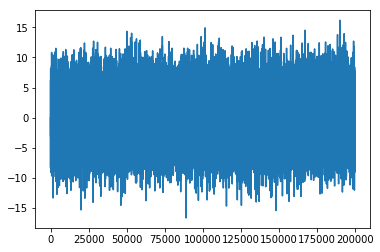

In [8]:
inp_cur = mon.I[0]/nA
plot(inp_cur);

In [9]:
out_spikes = [spike_mon.spike_trains()[0]/ms]
out_spikes

[array([  15.47,   30.37,   86.93,  152.92,  214.66,  228.57,  308.97,
         350.4 ,  389.2 ,  405.36,  436.46,  504.24,  535.26,  549.18,
         570.26,  586.02,  597.96,  621.44,  638.2 ,  665.94,  671.38,
         724.35,  736.21,  752.12,  780.58,  802.46,  889.08,  926.34,
         966.55,  974.25, 1007.61, 1024.67, 1104.55, 1134.71, 1221.06,
        1233.55, 1288.88, 1301.86, 1313.58, 1326.98, 1333.88, 1350.6 ,
        1403.06, 1441.07, 1460.55, 1467.24, 1489.03, 1666.05, 1693.64,
        1701.46, 1711.15, 1723.9 , 1751.72, 1762.81, 1770.45, 1791.43,
        1798.39, 1815.02, 1834.69, 1844.75, 1860.73, 1872.56, 1880.4 ,
        1885.89, 1895.2 , 1903.23, 1931.3 , 1942.72, 1991.44])]

## AdEx

In [10]:
start_scope()

In [11]:
# Parameters
C = 171 * pF
# gL = 60 * nS
gL = 6.16243899e-08*siemens
taum = C / gL
EL = -65 * mV
VT = -50.4 * mV
DeltaT = 5 * mV
Vcut = VT + 50 * DeltaT

In [12]:
taum

2.77487534 * msecond

In [13]:
# Pick an electrophysiological behaviour
tauw, a, b, Vr = 124*ms, 4*nS, 0.0805*nA, -70.6*mV # Regular spiking (as in the paper)


In [14]:
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I(t) - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
"""

In [15]:
I = TimedArray(inp_cur*nA, dt=dt)

In [16]:
neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=Vr; w+=b", method='exponential_euler')
neuron.vm = EL
trace = StateMonitor(neuron, 'vm', record=0)
spike_mon = SpikeMonitor(neuron)

In [17]:
run(30*ms)

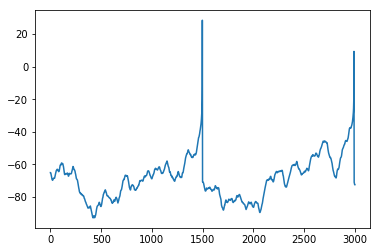

In [18]:
plot(trace.vm.transpose()/mV);

## Model Fitting

In [19]:
eqs = Equations(
"""
taum = C / gL : second
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + I*k - w)/C : volt
dw/dt = (a*(v - EL) - w)/tauw : amp
Vcut = VT + 50 * DeltaT : volt
gL: siemens (constant)
a : siemens (constant)
b : amp (constant)
VT : volt (constant)
DeltaT : volt (constant)
Vr : volt (constant)
k : 1 (constant)
""", 
# EL : volt (constant)
# C: farad (constant)
# gL = 60 * nS,
# VT = -50.4 * mV,
# DeltaT = 5 * mV,    
# a = 4*nS,
# b = 0.0805*nA,
# Vr = -70.6*mV
EL = -65 * mV,
C = 171 * pF,
tauw = 144*ms,
)

In [20]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=300*ms, delta=30*ms)

In [21]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                         input=[inp_cur] * nA, output=out_spikes,
                     n_samples=30,
                     threshold='v>Vcut',
                     reset="v=Vr; w+=b",
                     param_init={'v': -65*mV},
                     )

In [22]:
result_dict, error = fitter.fit(n_rounds=10,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                gL=[10*nS, 1000*nS],
                                a = [0, 200]*nS,
                                b = [0, 100]*nA,
                                VT = [-90, -10] * mV,
                                DeltaT = [0.1, 100] * mV,    
                                Vr = [-90, -30]*mV,
                                k = [0.01, 2]
                               )

WARNING    "gL" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value 61.6243899 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "VT" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value -50.4 * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "DeltaT" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value 5. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "a" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value 4. * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Vcut" is an internal variable of group "neurons", but also e

Round 0: fit (7.875579622978525e-07, -0.07629031990859782, -0.051510046718506126, 0.05511081383864404, 1.3225993143347918, 1.1926185492948856e-08, 1.173195108603049e-07) with error: 0.03211805555555558
Round 1: fit (8.378080381031312e-07, -0.07589960642261677, -0.044219108679844264, 0.03913871541165664, 1.2942548186961789, 1.0901647301482998e-08, 1.621952161551257e-07) with error: 0.01211734693877542
Round 2: fit (8.378080381031312e-07, -0.07589960642261677, -0.044219108679844264, 0.03913871541165664, 1.2942548186961789, 1.0901647301482998e-08, 1.621952161551257e-07) with error: 0.01211734693877542
Round 3: fit (8.355319222363924e-07, -0.06632835924378977, -0.036456660739750194, 0.04477851875908532, 1.8229591456712386, 9.312387044524259e-09, 1.697158282029167e-07) with error: 0.00251677852348986
Round 4: fit (8.355319222363924e-07, -0.06632835924378977, -0.036456660739750194, 0.04477851875908532, 1.8229591456712386, 9.312387044524259e-09, 1.697158282029167e-07) with error: 0.0025167785

In [23]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

WARNING    "gL" is an internal variable of group "neurons_", but also exists in the group-specific namespace with the value 61.6243899 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "VT" is an internal variable of group "neurons_", but also exists in the group-specific namespace with the value -50.4 * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "DeltaT" is an internal variable of group "neurons_", but also exists in the group-specific namespace with the value 5. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "a" is an internal variable of group "neurons_", but also exists in the group-specific namespace with the value 4. * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Vcut" is an internal variable of group "neurons_", but a

spike times: [array([3.10000e-01, 5.30000e-01, 7.80000e-01, 1.06000e+00, 1.50000e+00,
       2.30000e+00, 4.82600e+01, 4.88700e+01, 9.95900e+01, 1.00200e+02,
       1.44800e+02, 1.76540e+02, 1.77320e+02, 2.24900e+02, 2.58420e+02,
       2.83110e+02, 3.09040e+02, 3.40890e+02, 3.41490e+02, 3.89100e+02,
       3.90130e+02, 4.39150e+02, 4.68140e+02, 5.01090e+02, 5.01590e+02,
       5.45510e+02, 5.76890e+02, 6.09390e+02, 6.10630e+02, 6.58160e+02,
       6.59160e+02, 7.04790e+02, 7.35090e+02, 7.67380e+02, 7.90480e+02,
       7.91010e+02, 8.43680e+02, 8.75130e+02, 9.01280e+02, 9.02190e+02,
       9.51470e+02, 9.75140e+02, 1.00486e+03, 1.03887e+03, 1.07000e+03,
       1.09341e+03, 1.09421e+03, 1.14510e+03, 1.16912e+03, 1.20233e+03,
       1.22692e+03, 1.25814e+03, 1.25951e+03, 1.30550e+03, 1.33054e+03,
       1.33118e+03, 1.38381e+03, 1.41202e+03, 1.43783e+03, 1.46689e+03,
       1.46750e+03, 1.52013e+03, 1.55145e+03, 1.55216e+03, 1.59698e+03,
       1.62696e+03, 1.65582e+03, 1.65642e+03, 1.70

In [24]:
fits = fitter.generate(params=None, output_var='v',)

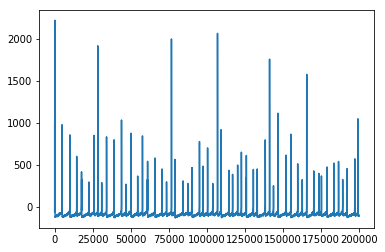

In [25]:
# Vizualize the resutls
# plot(voltage);
plot(fits[0]/mV)
plt.show()

In [26]:
np.array(spikes)

array([[3.10000e-01, 5.30000e-01, 7.80000e-01, 1.06000e+00, 1.50000e+00,
        2.30000e+00, 4.82600e+01, 4.88700e+01, 9.95900e+01, 1.00200e+02,
        1.44800e+02, 1.76540e+02, 1.77320e+02, 2.24900e+02, 2.58420e+02,
        2.83110e+02, 3.09040e+02, 3.40890e+02, 3.41490e+02, 3.89100e+02,
        3.90130e+02, 4.39150e+02, 4.68140e+02, 5.01090e+02, 5.01590e+02,
        5.45510e+02, 5.76890e+02, 6.09390e+02, 6.10630e+02, 6.58160e+02,
        6.59160e+02, 7.04790e+02, 7.35090e+02, 7.67380e+02, 7.90480e+02,
        7.91010e+02, 8.43680e+02, 8.75130e+02, 9.01280e+02, 9.02190e+02,
        9.51470e+02, 9.75140e+02, 1.00486e+03, 1.03887e+03, 1.07000e+03,
        1.09341e+03, 1.09421e+03, 1.14510e+03, 1.16912e+03, 1.20233e+03,
        1.22692e+03, 1.25814e+03, 1.25951e+03, 1.30550e+03, 1.33054e+03,
        1.33118e+03, 1.38381e+03, 1.41202e+03, 1.43783e+03, 1.46689e+03,
        1.46750e+03, 1.52013e+03, 1.55145e+03, 1.55216e+03, 1.59698e+03,
        1.62696e+03, 1.65582e+03, 1.65642e+03, 1.70

In [27]:
np.array(out_spikes)/0.01

array([[  1547.,   3037.,   8693.,  15292.,  21466.,  22857.,  30897.,
         35040.,  38920.,  40536.,  43646.,  50424.,  53526.,  54918.,
         57026.,  58602.,  59796.,  62144.,  63820.,  66594.,  67138.,
         72435.,  73621.,  75212.,  78058.,  80246.,  88908.,  92634.,
         96655.,  97425., 100761., 102467., 110455., 113471., 122106.,
        123355., 128888., 130186., 131358., 132698., 133388., 135060.,
        140306., 144107., 146055., 146724., 148903., 166605., 169364.,
        170146., 171115., 172390., 175172., 176281., 177045., 179143.,
        179839., 181502., 183469., 184475., 186073., 187256., 188040.,
        188589., 189520., 190323., 193130., 194272., 199144.]])

In [28]:
spikes[0][0]

0.31

In [29]:
rcParams["scatter.marker"] = "|"

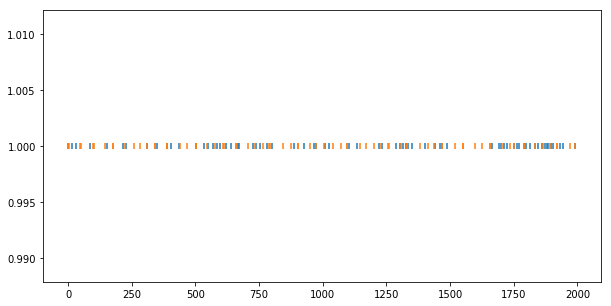

In [30]:
plt.figure(figsize=(10,5))
scatter(out_spikes[0], np.ones_like(out_spikes[0]));
scatter(spikes[0], np.ones_like(spikes[0]));

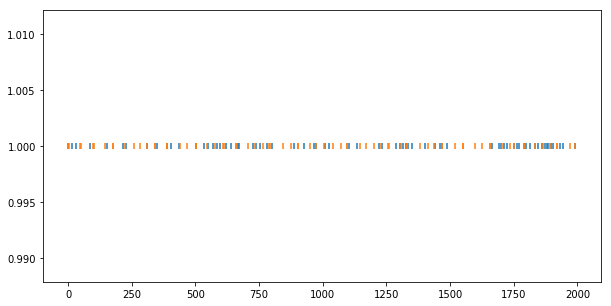

In [31]:
plt.figure(figsize=(10,5))

scatter(out_spikes[0], np.ones_like(out_spikes[0]));
scatter(spikes[0], np.ones_like(spikes[0]));

In [32]:
diff = out_spikes[0] - spikes[0]
plt.figure(figsize=(10,5))

ValueError: operands could not be broadcast together with shapes (69,) (80,) 

In [ ]:
plot(spikes[0])